# Import Packages

In [261]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pytz 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ast
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator


# Import Data

In [262]:
df = pd.read_csv('data/data_extraction/Isotonic_all.csv')

jakarta = pytz.timezone('Asia/Jakarta')
df['datetime_created'] = df['created_at'].apply(lambda x: datetime.strptime(x,'%a %b %d %H:%M:%S %z %Y').replace(tzinfo=pytz.UTC).astimezone(jakarta))
df['date_created'] = df['datetime_created'].apply(lambda x: x.date())
df['time_created'] = df['datetime_created'].apply(lambda x: x.time())
df = df.drop(['datetime_created'],axis=1)

In [263]:
df.head(10)

,Product,id,created_at,source,original_text,clean_text,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,date_created,time_created
0,Mizone,1.350000e+18,Wed Jan 20 01:19:59 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@chridst tidak suuzone karena gue maunya mizone, ayo beri satu",tidak suuzone maunya mizone ayo,in,0,0,heouaisha,False,"coveriklan, voiceover, pengisisuara, votalent",chridst,forever disneyfams.,"[[112.59649, -8.131789], [112.69126, -8.131789], [112.69126, -8.04802], [112.59649, -8.04802]]",2021-01-20,08:19:59
1,Mizone,1.350000e+18,Tue Jan 19 18:19:53 +0000 2021,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@bdngfess Nu kieu yeuh kangen berat sabelah teh\r\nInget nder iklan mizone,nu kieu yeuh kangen sabelah tehinget nder iklan mizone,in,0,0,Kasoy29,False,"RakyatDikelabui, RakyatDikelabui",bdngfess,"6°48'21.7""S 107°37'12.8""E","[[101.4761877, 2.9745362], [101.6291504, 2.9745362], [101.6291504, 3.1279044], [101.4761877, 3.1...",2021-01-20,01:19:53
2,Mizone,1.350000e+18,Tue Jan 19 17:13:16 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@menggelinjanq @andhikahehe @KarlinaFebri19 yaudah, deddy mizone",ya sudah deddy mizone,in,0,0,JosriSeptianto,False,NaN,"menggelinjanq, andhikahehe, KarlinaFebri19",haūs : ngoog,"[[116.1127404, -8.623615], [116.164731, -8.623615], [116.164731, -8.563715], [116.1127404, -8.56...",2021-01-20,00:13:16
3,Mizone,1.350000e+18,Tue Jan 19 14:42:05 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",@tjaennie @minjoooz @chaerylei @ljungwu pake z berasa mizone,pakai z berasa mizone,in,0,0,heetjins,False,NaN,"tjaennie, minjoooz, chaerylei, ljungwu",lost,"[[116.0689, -8.651347], [116.1688219, -8.651347], [116.1688219, -8.60494], [116.0689, -8.60494]]",2021-01-19,21:42:05
4,Mizone,1.350000e+18,Tue Jan 19 14:25:49 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@subtanyarl waktu umur 2 tahunan GUE MINUM MINYAK GAS HAHAHAA, terus seisi rumah pada panik. ken...",umur tahunan minum minyak gas hahahaa seisi rumah panik minum minyak tidak tuh minyak botol nya ...,in,0,0,oxylome,False,NaN,subtanyarl,vottom🍊,"[[106.721034, -6.217601], [106.770437, -6.217601], [106.770437, -6.154872], [106.721034, -6.1548...",2021-01-19,21:25:49
5,Mizone,1.350000e+18,Tue Jan 19 14:07:58 +0000 2021,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Aqua bisa ekspansi pasarnya dan buka pabrik tambahan sana sini yg bikin produksi &amp; aktivitas...,aqua ekspansi pasarnya buka pabrik tambahan bikin produksi amp aktivitas perusahaannya bikin miz...,in,0,0,taequela,False,NaN,msofyan,Zimbabwe,NaN,2021-01-19,21:07:58
6,Mizone,1.350000e+18,Tue Jan 19 12:01:15 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",fancam ujung dance dreams come true di indomaret wjsn xuanyi chengxiao bona mizone https://t.co...,fancam ujung dance dreams come true indomaret wjsn xuanyi chengxiao bona mizone,in,0,0,kenapajak,False,NaN,subtanyarl,"Lombok Barat, Nusa Tenggara Ba",NaN,2021-01-19,19:01:15
7,Mizone,1.350000e+18,Tue Jan 19 07:10:26 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",@msofyan Kacang kacang kacang...\r\nTahu tahu tahu....\r\nMizone nya kak https://t.co/5BY81L1oZP,kacang kacang kacang mizone nya kak,in,0,0,heffheven,False,NaN,FiersaBesari,⌗ ❍ SHE/HER O5TEEN \r\n,NaN,2021-01-19,14:10:26
8,Mizone,1.350000e+18,Mon Jan 18 20:48:17 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@subtanyarl kalo lagi sakit minum nya bear brand, kalo lagi capek minum nya pocari sweat/ mizone...",sakit minum nya bear brand capek minum 

In [264]:
len(df)

837

Removing Duplicate if any

In [265]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [266]:
len(df)

837

# Extra Cleaning

In [267]:
pd.set_option('display.max_colwidth', None)
df[df['clean_text'].isnull()==True]['original_text']

Series([], Name: original_text, dtype: object)

Removing Observation that the text become empty after cleaning, indicating that the text doesn't have significance sentiment

In [268]:
df = df.dropna(subset=['clean_text'])
df = df.reset_index(drop=True)

In [269]:
df.isnull().sum()

Product                     0
id                          0
created_at                  0
source                      0
original_text               0
clean_text                  0
lang                        0
favorite_count              0
retweet_count               0
original_author             0
possibly_sensitive        721
hashtags                  784
user_mentions             243
place                     300
place_coord_boundaries    824
date_created                0
time_created                0
dtype: int64

In [270]:
df[df['lang']!='in']['lang'].value_counts()

java    1
Name: lang, dtype: int64

As there are some word not in Indonesian, possibly indonesian people using other language to tweet, those text will be translated in order to process the text

In [271]:
def trans(x,src):
    translator = Translator()
    try:
        sentence = translator.translate(x, src=src,dest='id').text
    except:
        
        
        sentence = x
    return sentence

In [272]:
df['clean_text'] = df.apply(lambda x: trans(x['clean_text'],x['lang']) if(x['lang']!='in') else x['clean_text'],axis=1)

In [273]:
clean_text = df['clean_text'].copy()

In [274]:
pd.set_option('display.max_colwidth', 100)
clean_text.tail(15)

822                                          hand sanitizer masker hydro coco bits ikutan follow like akun
823                                                                                        hydro coco aneh
824                                                  geus paling benar hydro coco oplos susu beruang ieumh
825                                                                          tim hydro coco or pocarisweat
826                                                                          tim hydro coco or pocarisweat
827                                                                            hydro coco susu beruang jos
828                                                                           kasih hydro coco biar netral
829    perdana sukses makmurneed spg mobile product adem sari hydro coco serius pekerjaan motor ulet ju...
830                   sak kecamatan ae cukup sampian rene mbak kerjo ning pabrik hydro coco tidak sherlock
831    moga dicoba hydro coco mudah d

In [275]:
def repair_exaggeration(x):
    word_tokens = word_tokenize(x)
    new_x =''
    for i in word_tokens:
        if (i =='susu'):
            new = re.sub(r'(\w)\1\1+',r'\1\1',i)
            new_x = new_x +new+' '
        elif(i =='cucu'):
            new = 'susu'
            new_x = new_x +new+' '
        else:
            new = re.sub(r'(\w)\1\1\1+',r'\1',i)
            new_x = new_x +new+' '
    return new_x


def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

def clean_tweets(tweet):
   # nltk.download('stopwords')
    my_file = open("cleaning_source/combined_stop_words.txt", "r")
    content = my_file.read()
    stop_words = content.split("\n")
    file_2  = open("cleaning_source/update_combined_slang_words.txt", "r")
    content2 = file_2.read()
    slang_words = ast.literal_eval(content2)
    my_file.close()
    file_2.close()

    tweet = tweet.lower()
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    #remove emojis from tweet
    #tweet = emoji_pattern.sub(r'', tweet)
    
    #remove punctuation manually
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    
    #remove tags
    tweet=re.sub("&lt;/?.*?&gt;","&lt;&gt;",tweet)
    
    #remove digits and special chars
    tweet=re.sub("(\\d|\\W)+"," ",tweet)

    #remove other symbol from tweet
    tweet = re.sub(r'â', '', tweet)
    tweet = re.sub(r'€', '', tweet)
    tweet = re.sub(r'¦', '', tweet)

    word_tokens = word_tokenize(tweet)
    for w in word_tokens:
        if w in slang_words.keys():
            word_tokens[word_tokens.index(w)] = slang_words[w]

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []

    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in string.punctuation:
            filtered_tweet.append(w.lower())
    return ' '.join(filtered_tweet)

def count_words(x):
    words = word_tokenize(x)
    n=len(words)
    return n

Cleaning text that exaggerate the typing such as 'cucu (susu)'

In [276]:
clean_text_exag = clean_text.apply(lambda x: repair_exaggeration(x))

Recleaning after remove exaggeration

In [277]:
re_clean = clean_text_exag.apply(lambda x: clean_tweets(x))

we use keywords for querying data, now we need to remove them as it will all found in every sentence in this data frame

In [278]:
keyword = []
clean_text_extra = re_clean.apply(lambda x: del_word(x,keyword))

In [279]:
clean_text_extra.tail(15)

822                                         hand sanitizer masker hydro coco bits ikutan follow like akun 
823                                                                                       hydro coco aneh 
824                                                 geus paling benar hydro coco oplos susu beruang ieumh 
825                                                                        tim hydro coco or pocari sweat 
826                                                                        tim hydro coco or pocari sweat 
827                                                                           hydro coco susu beruang jos 
828                                                                          kasih hydro coco biar netral 
829    perdana sukses makmurneed spg mobile product adem sari hydro coco serius pekerjaan motor ulet ju...
830                        sak kecamatan ae sampian rene mbak kerjo ning pabrik hydro coco tidak sherlock 
831    moga dicoba hydro coco mudah d

In [280]:
df['clean_text'] = clean_text_extra

In [281]:
df['word_length'] = df['clean_text'].apply(lambda x:count_words(x))

In [282]:
df['word_length'].value_counts().sort_index()

1      5
2     53
3     43
4     57
5     67
6     61
7     54
8     45
9     50
10    47
11    37
12    54
13    39
14    21
15    27
16    16
17    23
18    12
19    10
20     8
21    12
22    26
23    10
24     7
25     7
26     7
27     4
28     9
29     8
30     5
31     4
32     3
33     3
35     2
38     1
Name: word_length, dtype: int64

In [283]:
df = df.drop(df[df['word_length']==0].index,axis=0)
df = df.reset_index(drop=True)

# Word Processing¶


## Create word dictionary

In [284]:
word_dict = {}
for i in range(0,len(df['clean_text'])):
    sentence = df['clean_text'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [285]:
len(word_dict)

2690

In [286]:
len({k:v for (k,v) in word_dict.items() if v < 4})

2318

## Import Lexicon data


import lexicon, and remove negation words from lexicon, the lexicon is a combination from several sources below, that combined together, and include swear words which has the most negative score

sources :

https://github.com/louisowen6/NLP_bahasa_resources

https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt

https://github.com/fajri91/InSet

https://github.com/agusmakmun/SentiStrengthID/blob/master/id_dict/sentimentword.txt

In [287]:
negasi = ['bukan','tidak','ga','gk', 'gak']
lexicon = pd.read_csv('lexicon/modified_full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                               |(lexicon['word'] == 'tidak')
                               |(lexicon['word'] == 'ga')|(lexicon['word'] == 'gk') | (lexicon['word'] == 'gak')].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [288]:
len(lexicon)

10265

In [289]:
lexicon.head(20)

,word,weight,number_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,bisa,5,1
5,detail,2,1
6,pernik,3,1
7,belas,2,1
8,welas,4,1
9,kabung,1,1


In [290]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [291]:
len(lexicon_word)

10265

Checking if there is words in dictionary that does not included in the lexicon

In [292]:
ns_words = []
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)
len(ns_words)

1798

Let's take a look what kind of words they are, lets start with some words that have many occurences as this most likely not a type case

In [293]:
len({k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3)) })

203

In [294]:
ns_words_list = {k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3))}

In [295]:
sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse=True)
sort_orders=sort_orders[0:20]
for i in sort_orders:
    print(i[0], i[1])

bear 277
brand 265
beruang 241
pocari 162
sweat 158
coco 112
hydro 109
tidak 86
ga 84
pakai 52
naga 46
si 44
iklan 42
nya 42
kucing 42
vitamin 38
sih 34
deh 30
c 28
nder 27


In [296]:
word_to_plot = df['original_author'].copy()

In [297]:
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

creating word cloud to see what kind of words that appear often in the tweets related to the product

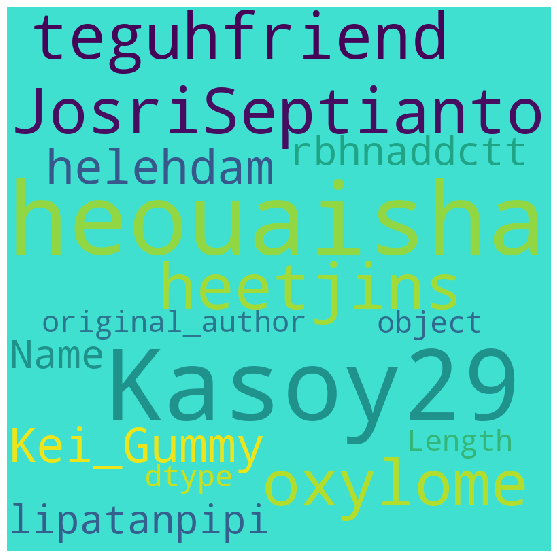

In [298]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'turquoise', max_words = 1500
                      , min_font_size = 20).generate(str(word_to_plot))
#plot the word cloud
fig = plt.figure(figsize = (10,10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

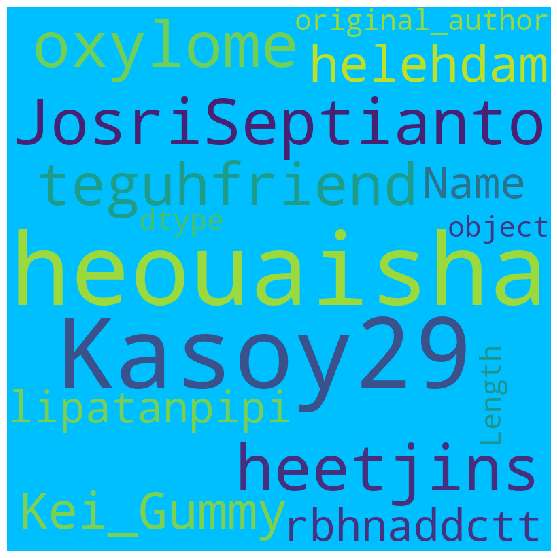

In [299]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'deepskyblue', max_words = 1500
                      , min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
fig = plt.figure(figsize = (10,10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## sentiment

In [300]:
lexicon['number_of_words'].value_counts()

1    9552
2     686
3      24
4       2
0       1
Name: number_of_words, dtype: int64

calculating the sentiment of words by mathing them to the lexicon while also creating the bag of words matrix

In [301]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['clean_text'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [302]:
len(sentiment_list)

837

In [303]:
print(senrow.shape[0])

837


constructing the data frame that contain bag of words and the sentiments that have been calculated before

In [304]:
sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [305]:
df_sen

,maunya,mizone,ayo,kangen,berasa,umur,minum,gas,isi,rumah,...,sukses,pantang,menyerah,belok,kiri,dicoba,derita,kesulitan,bermanfaat,sentiment
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2
4,0,2,0,0,0,1,3,2,1,1,...,0,0,0,0,0,0,0,0,0,-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,1,1,1,8
833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [306]:
df_sen.head(10)

,maunya,mizone,ayo,kangen,berasa,umur,minum,gas,isi,rumah,...,sukses,pantang,menyerah,belok,kiri,dicoba,derita,kesulitan,bermanfaat,sentiment
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2
4,0,2,0,0,0,1,3,2,1,1,...,0,0,0,0,0,0,0,0,0,-11
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,-7
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2



lets see if the sentiment is correct by looking at the original text

In [307]:
cek_df = pd.DataFrame([])
cek_df['text'] = df['original_text'].copy()
cek_df['sentiment']  = df_sen['sentiment'].copy()

In [308]:
cek_df

,text,sentiment
0,"@chridst tidak suuzone karena gue maunya mizone, ayo beri satu",3
1,@bdngfess Nu kieu yeuh kangen berat sabelah teh\r\nInget nder iklan mizone,3
2,"@menggelinjanq @andhikahehe @KarlinaFebri19 yaudah, deddy mizone",0
3,@tjaennie @minjoooz @chaerylei @ljungwu pake z berasa mizone,-2
4,"@subtanyarl waktu umur 2 tahunan GUE MINUM MINYAK GAS HAHAHAA, terus seisi rumah pada panik. ken...",-11
...,...,...
832,Ada diantara penderita covid yang kesulitan makan karena selera seperti hilang dan purutpun mual...,8
833,@pipigembulkei Knp ada royco heyyy 😅 jangan bilang mau di seduh sama Hydro coco 🤣🤣,0
834,"@mauchatimedong Ngefek sii. Kalau mau tambah seger ntar pas bangun tidur, susu beruangnya bisa t...",7
835,@kegblgnunfaedh Sabtu jam 5 pagi kala itu beli hydro coco..\r\nMasa lalu 😂🤣,3


## EDA

Text(0.5, 0, 'sentiment')

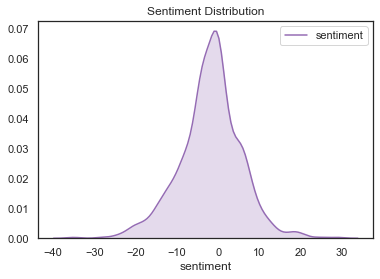

In [309]:
sns.set(style="white", palette="muted", color_codes=True)
sns.kdeplot(df_sen['sentiment'],color='m',shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('sentiment')

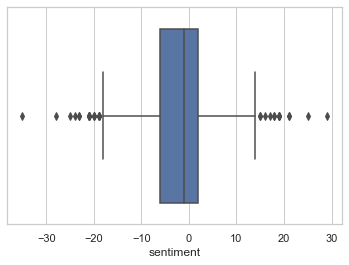

In [310]:
sns.set(style="whitegrid") 
sns.boxplot(x=df_sen['sentiment'])

In [311]:
df_sen.describe()

,maunya,mizone,ayo,kangen,berasa,umur,minum,gas,isi,rumah,...,sukses,pantang,menyerah,belok,kiri,dicoba,derita,kesulitan,bermanfaat,sentiment
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,...,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,0.004779,0.111111,0.002389,0.001195,0.010753,0.002389,0.292712,0.003584,0.011947,0.032258,...,0.001195,0.001195,0.001195,0.001195,0.001195,0.002389,0.001195,0.001195,0.001195,-1.868578
std,0.069006,0.332934,0.048853,0.034565,0.103198,0.048853,0.642667,0.077253,0.108714,0.176790,...,0.034565,0.034565,0.034565,0.034565,0.034565,0.069130,0.034565,0.034565,0.034565,7.431308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-35.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,29.000000


Now let's take a look at the correlation between words that is included in the sentiment

In [312]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

#print("Top Absolute Correlations")
#print(get_top_abs_correlations(df_sen, 10))
au = get_top_abs_correlations(df_sen, 15)

In [313]:
print('Perfect Correlation')
au[au==1]

Perfect Correlation


donor      darah        1.0
menolak    super        1.0
kunjung    biji         1.0
mati       sisa         1.0
banding    pemberian    1.0
                       ... 
pol        ramai        1.0
kesabaran  kebaca       1.0
berguna    ajak         1.0
teriak     serentak     1.0
sukses     kiri         1.0
Length: 271, dtype: float64

it turns out that there are 261 word that always occur together in every text, although we dont really see how much of the sentences that is included there but the correlation is pretty high

In [314]:
top10 = au[au<float(1)][0:10]
label = top10.index
label_list =[]
for i in label:
    for j in i:
        if(j not in label_list):
            label_list.append(j)
            
df_sen_corr = df_sen[label_list]
corr = df_sen_corr.corr()
for i in label_list:
    for j in label_list:
        if i!=j:
            corr[i][j] = round(corr[i][j],3)

now let's take a look at other word, that is now always but often come together as the correlation quite high althoughh not equal to 1

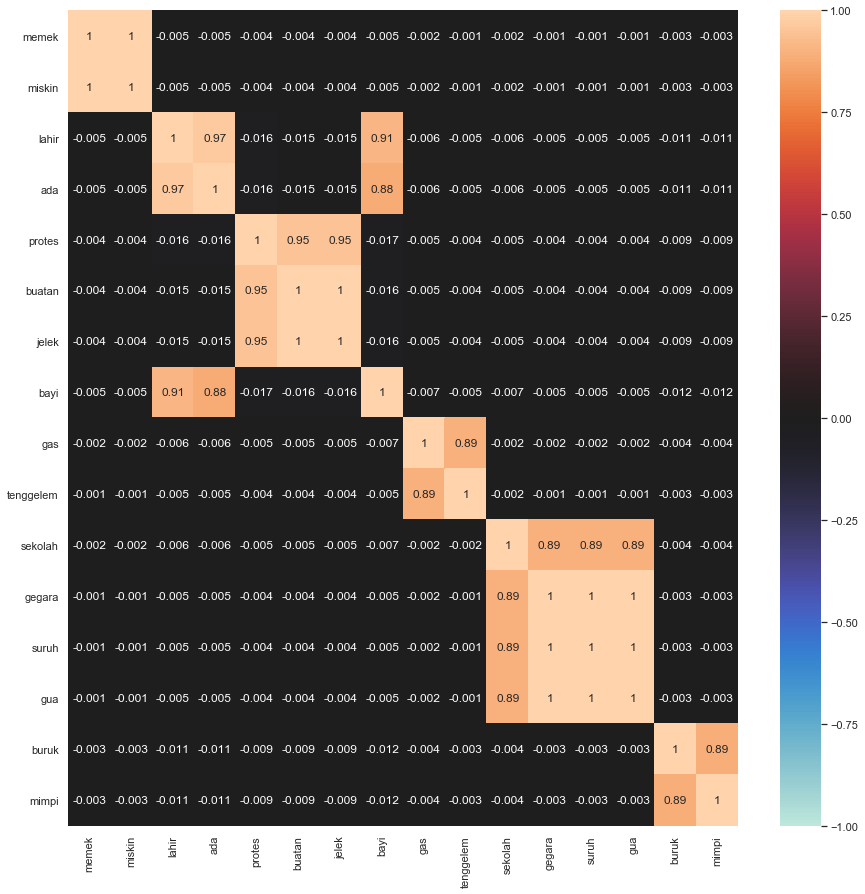

In [315]:
plt.figure(figsize=(15,15))

h = sns.heatmap(corr, annot=True,vmin=-1, vmax=1, center= 0)

plt.show()

In [316]:
top15 = au[au<float(1)][0:20]

In [317]:
au

donor    darah            1.000000e+00
menolak  super            1.000000e+00
kunjung  biji             1.000000e+00
mati     sisa             1.000000e+00
banding  pemberian        1.000000e+00
                              ...     
makan    alhamdulillah    9.670284e-05
rumah    suka             2.813626e-16
mizone   berasa           1.955260e-17
         anak             1.420305e-17
         rumah            1.210971e-17
Length: 286146, dtype: float64

In [318]:
correlation = pd.DataFrame(au[au<float(1)][0:291466])

In [319]:
correlation.to_excel("wordpairs_isotonic.xlsx")

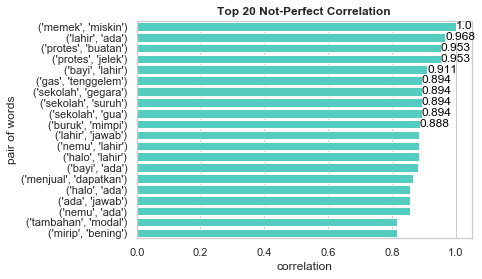

In [320]:
pal =sns.dark_palette("purple", input="xkcd",n_colors=15)
g = sns.barplot(y = top15.index , x = top15,color='turquoise')
g.grid=False
plt.xlabel('correlation')
plt.ylabel('pair of words')
plt.title("Top 20 Not-Perfect Correlation",fontweight='bold') 
for i in range(10):
    g.text(top15[i],i+0.22, round(top15[i],3),color='black')
plt.show()

now lets take a look at the most occured words among the set of words that is included in lexicon

In [321]:
top15_word = df_sen.drop(['sentiment'],axis=1).sum().sort_values(ascending=False)[0:15]

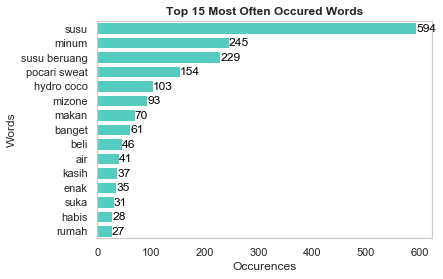

In [322]:
#pal =sns.dark_palette("purple", input="xkcd",n_colors=15)
pal =sns.light_palette("navy", reverse=True,n_colors=15)
g = sns.barplot(y = top15_word.index , x = top15_word, color='turquoise')
g.grid(False)
plt.xlabel('Occurences')
plt.ylabel('Words')
plt.title("Top 15 Most Often Occured Words",fontweight='bold') 
for i in range(15):
    g.text(top15_word[i],i+0.22, top15_word[i],color='black')
plt.show()

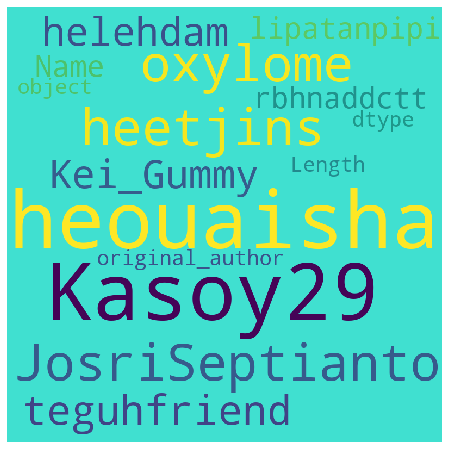

In [323]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'turquoise', max_words = 1500
                      , min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [324]:
mask = np.array(Image.open("twitter_mask.png"))

In [325]:
colors = ["turquoise", "deepskyblue", 'darkcyan']

In [326]:
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

In [327]:
wc = WordCloud(width = 2000, height = 1600, random_state=1, background_color='white', 
               colormap=cmap , mask=mask, collocations=True, stopwords = STOPWORDS).generate(str(top15_word))

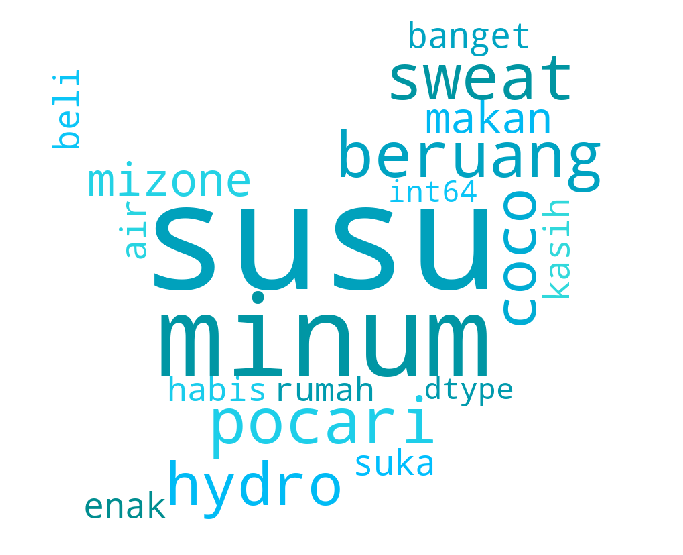

In [328]:
plt.figure(figsize=[12,12])
plt.imshow(wc)
plt.axis('off')
plt.show()

# Beyond Words

now we want to explore more than the word it self, hence we pass the sentiment into the original dataset and then explore some data there

In [329]:
df['sentiment'] = df_sen['sentiment']

In [330]:
df.head(5)

,Product,id,created_at,source,original_text,clean_text,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,date_created,time_created,word_length,sentiment
0,Mizone,1.350000e+18,Wed Jan 20 01:19:59 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@chridst tidak suuzone karena gue maunya mizone, ayo beri satu",tidak suuzone maunya mizone ayo,in,0,0,heouaisha,False,"coveriklan, voiceover, pengisisuara, votalent",chridst,forever disneyfams.,"[[112.59649, -8.131789], [112.69126, -8.131789], [112.69126, -8.04802], [112.59649, -8.04802]]",2021-01-20,08:19:59,5,3
1,Mizone,1.350000e+18,Tue Jan 19 18:19:53 +0000 2021,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@bdngfess Nu kieu yeuh kangen berat sabelah teh\r\nInget nder iklan mizone,nu kieu yeuh kangen sabelah tehinget nder iklan mizone,in,0,0,Kasoy29,False,"RakyatDikelabui, RakyatDikelabui",bdngfess,"6°48'21.7""S 107°37'12.8""E","[[101.4761877, 2.9745362], [101.6291504, 2.9745362], [101.6291504, 3.1279044], [101.4761877, 3.1...",2021-01-20,01:19:53,9,3
2,Mizone,1.350000e+18,Tue Jan 19 17:13:16 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@menggelinjanq @andhikahehe @KarlinaFebri19 yaudah, deddy mizone",deddy mizone,in,0,0,JosriSeptianto,False,NaN,"menggelinjanq, andhikahehe, KarlinaFebri19",haūs : ngoog,"[[116.1127404, -8.623615], [116.164731, -8.623615], [116.164731, -8.563715], [116.1127404, -8.56...",2021-01-20,00:13:16,2,0
3,Mizone,1.350000e+18,Tue Jan 19 14:42:05 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",@tjaennie @minjoooz @chaerylei @ljungwu pake z berasa mizone,pakai z berasa mizone,in,0,0,heetjins,False,NaN,"tjaennie, minjoooz, chaerylei, ljungwu",lost,"[[116.0689, -8.651347], [116.1688219, -8.651347], [116.1688219, -8.60494], [116.0689, -8.60494]]",2021-01-19,21:42:05,4,-2
4,Mizone,1.350000e+18,Tue Jan 19 14:25:49 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@subtanyarl waktu umur 2 tahunan GUE MINUM MINYAK GAS HAHAHAA, terus seisi rumah pada panik. ken...",umur tahunan minum minyak gas hahahaa seisi rumah panik minum minyak tidak tuh minyak botol nya ...,in,0,0,oxylome,False,NaN,subtanyarl,vottom🍊,"[[106.721034, -6.217601], [106.770437, -6.217601], [106.770437, -6.154872], [106.721034, -6.1548...",2021-01-19,21:25:49,28,-11


In [331]:
df.isnull().sum()

Product                     0
id                          0
created_at                  0
source                      0
original_text               0
clean_text                  0
lang                        0
favorite_count              0
retweet_count               0
original_author             0
possibly_sensitive        721
hashtags                  784
user_mentions             243
place                     300
place_coord_boundaries    824
date_created                0
time_created                0
word_length                 0
sentiment                   0
dtype: int64

lets take a look at the other factor that is correlated to the sentiment itself

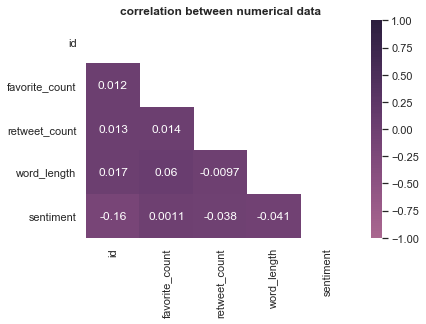

In [332]:
plt.figure()
plt.title('correlation between numerical data',fontweight='bold')
df_corr = df.corr()
matrix = np.triu(df.corr())
cmap =  sns.cubehelix_palette(light=0.5, as_cmap=True)
h = sns.heatmap(df_corr, annot=True,vmin=-1, vmax=1, center= 0,mask=matrix,cmap = cmap)

plt.show()

from the numerical feature, it seems the correlation is very low, now lets take a look at the others

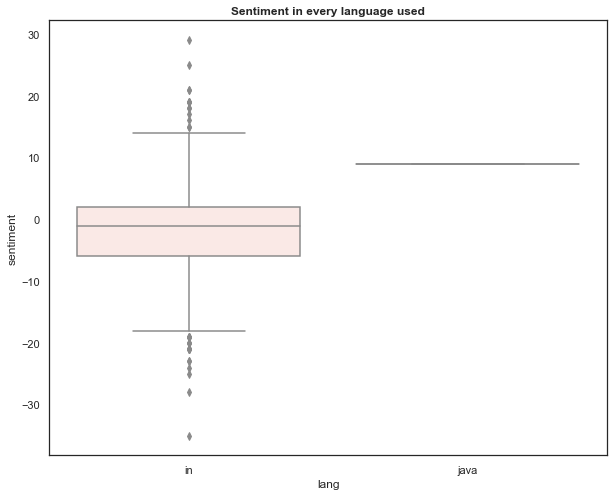

In [333]:
sns.set(style="white", color_codes=True)
plt.figure(figsize=(10,8))
plt.title('Sentiment in every language used',fontweight='bold')
l = sns.boxplot(x='lang',y='sentiment',data=df,palette= sns.color_palette("RdPu", 10))

it looks like people from this time frame that language 'ko' and 'und' always used to give positive sentiment while it is the opposite for 'pt' and 'es'

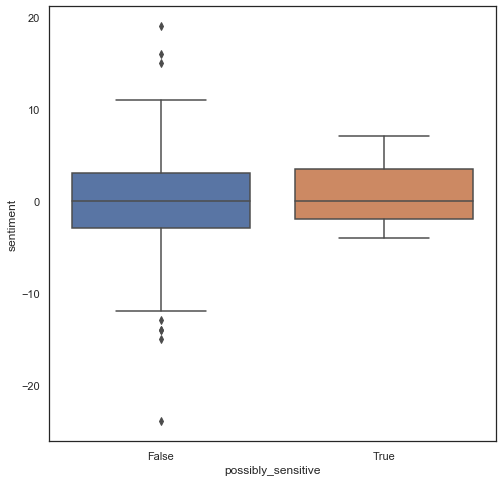

In [334]:
cek_df = df.dropna(subset=['possibly_sensitive'])
cek_df = cek_df.reset_index(drop=True)
plt.figure(figsize=(8,8))
g = sns.boxplot(x='possibly_sensitive',y='sentiment',data=cek_df)
plt.show()

the sensitive content does not indicating the statement as they are almost equally distributed among them

In [335]:
df

,Product,id,created_at,source,original_text,clean_text,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,date_created,time_created,word_length,sentiment
0,Mizone,1.350000e+18,Wed Jan 20 01:19:59 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@chridst tidak suuzone karena gue maunya mizone, ayo beri satu",tidak suuzone maunya mizone ayo,in,0,0,heouaisha,False,"coveriklan, voiceover, pengisisuara, votalent",chridst,forever disneyfams.,"[[112.59649, -8.131789], [112.69126, -8.131789], [112.69126, -8.04802], [112.59649, -8.04802]]",2021-01-20,08:19:59,5,3
1,Mizone,1.350000e+18,Tue Jan 19 18:19:53 +0000 2021,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@bdngfess Nu kieu yeuh kangen berat sabelah teh\r\nInget nder iklan mizone,nu kieu yeuh kangen sabelah tehinget nder iklan mizone,in,0,0,Kasoy29,False,"RakyatDikelabui, RakyatDikelabui",bdngfess,"6°48'21.7""S 107°37'12.8""E","[[101.4761877, 2.9745362], [101.6291504, 2.9745362], [101.6291504, 3.1279044], [101.4761877, 3.1...",2021-01-20,01:19:53,9,3
2,Mizone,1.350000e+18,Tue Jan 19 17:13:16 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@menggelinjanq @andhikahehe @KarlinaFebri19 yaudah, deddy mizone",deddy mizone,in,0,0,JosriSeptianto,False,NaN,"menggelinjanq, andhikahehe, KarlinaFebri19",haūs : ngoog,"[[116.1127404, -8.623615], [116.164731, -8.623615], [116.164731, -8.563715], [116.1127404, -8.56...",2021-01-20,00:13:16,2,0
3,Mizone,1.350000e+18,Tue Jan 19 14:42:05 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",@tjaennie @minjoooz @chaerylei @ljungwu pake z berasa mizone,pakai z berasa mizone,in,0,0,heetjins,False,NaN,"tjaennie, minjoooz, chaerylei, ljungwu",lost,"[[116.0689, -8.651347], [116.1688219, -8.651347], [116.1688219, -8.60494], [116.0689, -8.60494]]",2021-01-19,21:42:05,4,-2
4,Mizone,1.350000e+18,Tue Jan 19 14:25:49 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@subtanyarl waktu umur 2 tahunan GUE MINUM MINYAK GAS HAHAHAA, terus seisi rumah pada panik. ken...",umur tahunan minum minyak gas hahahaa seisi rumah panik minum minyak tidak tuh minyak botol nya ...,in,0,0,oxylome,False,NaN,subtanyarl,vottom🍊,"[[106.721034, -6.217601], [106.770437, -6.217601], [106.770437, -6.154872], [106.721034, -6.1548...",2021-01-19,21:25:49,28,-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,Hydro Coco,1.350000e+18,Sat Jan 09 08:47:04 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",Ada diantara penderita covid yang kesulitan makan karena selera seperti hilang dan purutpun mual...,penderita covid kesulitan makan selera hilang perut mual asupan masuk pengalaman cobalah minum h...,in,3,0,teguhfriend,NaN,NaN,fakeblis,"Tangerang, Banten",NaN,2021-01-09,15:47:04,25,8
833,Hydro Coco,1.350000e+18,Sun Jan 10 01:43:00 +0000 2021,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@pipigembulkei Knp ada royco heyyy 😅 jangan bilang mau di seduh sama Hydro coco 🤣🤣,yyy bilang seduh hydro coco,in,2,0,Kei_Gummy,NaN,HealthyHighVitaminCDrink,KimALCc,"Kediri, Jawa Timur",NaN,2021-01-10,08:43:00,5,0
834,Hydro Coco,1.350000e+18,Mon Jan 11 12:47:11 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","@mauchatimedong Ngefek sii. Kalau mau tambah seger ntar pas bangun tidur, susu beruangnya bisa t...",ngefek sii seger pas bangun tidur susu beruangnya tu campur hydro coco nata adik coco,in,0,0,helehdam,False,HealthyHighVitaminCDrink,kegblgnunfaedh,"Lebak, Banten",NaN,2021-01-11,19:47:11,15,7
835,Hydro Coco,1.350000e+18,Mon Jan 11 03:06:11 +0000 2021,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitte

In [336]:
df_place = df.groupby(['place']).mean().sort_values(by='sentiment',ascending=False)
df_place = df_place.reset_index()

In [337]:
df_place_dict = df.groupby(['place']).count().sort_values(by='id',ascending=False)['id'].to_dict()

In [338]:
df_place['number_of_tweets'] =  df_place.apply(lambda x:df_place_dict[x['place']],axis=1)

In [339]:
top10_place_pos = df_place.sort_values(by='sentiment',ascending=False)[0:10].reset_index(drop=True)
top10_place_neg = df_place.sort_values(by='sentiment',ascending=True)[0:10].reset_index(drop=True)
top10_place     = df_place.sort_values(by='number_of_tweets',ascending=False)[0:10].reset_index(drop=True)

now let's take a look at some places where the sentiment that is made from them is tend to be sensitive and also for places that made otherwise

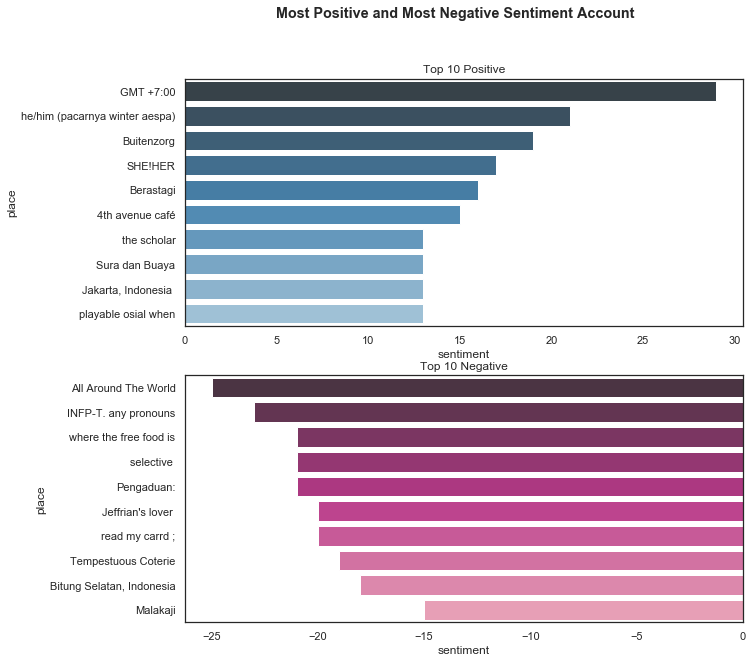

<Figure size 432x288 with 0 Axes>

In [340]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10))
fig.suptitle('Most Positive and Most Negative Sentiment Account',fontweight='bold')
h = sns.barplot(y='place',x='sentiment',data=top10_place_pos,ax=ax1,palette=sns.color_palette("Blues_d",n_colors=10))
n = sns.barplot(y='place',x='sentiment',data=top10_place_neg,ax=ax2,palette=sns.color_palette('RdPu_d',n_colors=10))
ax1.set_title('Top 10 Positive')
ax2.set_title('Top 10 Negative')
plt.show()
plt.savefig("most account.png", dpi=200)

last but not least, let's take a look at some places where tweets is most often come from


C:\Users\alldata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\alldata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 56425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\alldata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\alldata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 57339 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\alldata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 56615 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\alldata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 55357 mi

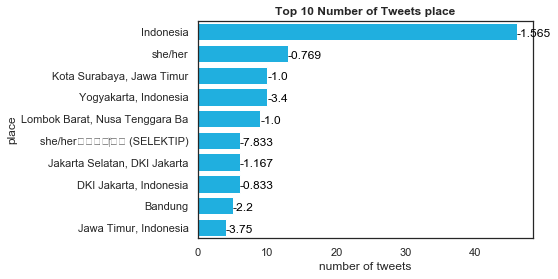

In [341]:
pal =sns.dark_palette("green", input="xkcd",n_colors=10)
g = sns.barplot(y = top10_place['place'] , x = top10_place['number_of_tweets'],color='deepskyblue')
g.grid=False
plt.xlabel('number of tweets')
plt.ylabel('place')
plt.title("Top 10 Number of Tweets place",fontweight='bold') 

for i in range(10):
    g.text(top10_place['number_of_tweets'][i], i+0.22 ,round(top10_place['sentiment'][i],3),color='black')
    
plt.show()